In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import chi2
from currency_converter import CurrencyConverter
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from pandas_profiling import ProfileReport
import shap
import re
import numpy as np

sns.set_style("darkgrid")

# Data Cleaning
- #### Pandas profiling for overall statistics
- #### Check data types
- #### Data distribution
- #### Check for NaN / missing values
- #### Check for duplicates
- #### Remove unecessary columns
- #### Feature engineering

## Campaign dataset

In [2]:
df_campaign = pd.read_csv('data/Campaign.csv')

### General data profiling

In [3]:
profile = ProfileReport(df_campaign, title="Campaign Report")

In [4]:
profile.to_widgets()

In [5]:
print('Campaign length: ', len(df_campaign))
print('Campaign columns: ',df_campaign.shape[1])

Campaign length:  32060
Campaign columns:  16


### Find NaN columns

In [6]:
nan_cols = [i for i in df_campaign.columns if df_campaign[i].isnull().any()]
print('Columns containing NaN :', nan_cols)

Columns containing NaN : ['name_title', 'created_account']


- #### Filling NaN in the name with blank
- #### Using title, first and last name to create a primary key to join the two sets on

In [7]:
df_campaign['name_title'].fillna('',inplace=True)

In [8]:
df_campaign['full_name'] = df_campaign['name_title'] + ' ' + df_campaign['first_name'] + ' ' + df_campaign['last_name']
df_campaign['full_name'] = df_campaign['full_name'].str.strip()

In [9]:
df_campaign['created_account'].fillna('N/A',inplace=True)

### Find duplicated columns

In [10]:
print('Total number of duplicated columns :', df_campaign.duplicated().sum())

Total number of duplicated columns : 0


### Describe the numeric data types to get a first idea on their distribution

In [11]:
df_campaign.describe()

,participant_id,age,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance
count,3.206000e+04,32060.000000,32060.000000,32060.000000,32060.000000,32060.000000,32060.000000
mean,4.973681e+12,38.564816,7.757673,13.207611,5.290331,5.170930,0.424891
std,2.883537e+12,13.637532,3.859709,3.353797,2.673795,2.550475,0.494334
min,8.859368e+07,17.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.493678e+12,28.000000,5.000000,12.000000,3.000000,3.000000,0.000000
50%,4.962955e+12,37.000000,8.000000,13.000000,5.000000,5.000000,0.000000
75%,7.470135e+12,48.000000,10.000000,16.000000,8.000000,7.000000,1.000000
max,9.999820e+12,90.000000,20.000000,21.000000,10.000000,10.000000,1.000000


### Check the data types

In [12]:
df_campaign.dtypes

participant_id          float64
name_title               object
first_name               object
last_name                object
age                       int64
postcode                 object
marital_status           object
education                object
job_title                object
occupation_level          int64
education_num             int64
familiarity_FB            int64
view_FB                   int64
interested_insurance      int64
company_email            object
created_account          object
full_name                object
dtype: object

### Check age distribution using bins
- #### Engineer new feature age_bracket based on the age bins

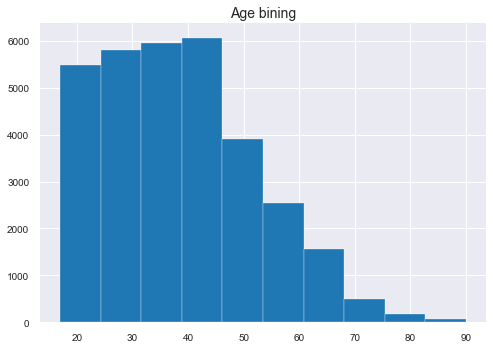

In [13]:
bins = df_campaign['age']
plt.hist(bins, bins=10)
plt.title('Age bining', fontsize=14)
plt.show()

In [14]:
def make_bins(df):
    bins = [16, 29, 39, 49, 59, 69, 79, 99]
    label_names = ['20s','30s','40s','50s','60s','70s','above 80s']
    df['age_bracket'] = pd.cut(df['age'], bins, labels=label_names)

In [15]:
make_bins(df_campaign)

### Find columns containing mixed types of data

In [16]:
def find_mix_types(df):
    for col in df.columns:
        weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis=1)
        if len(df[weird]) > 0:
            print(col)
        else:
            return 'No mixed columns'

In [17]:
find_mix_types(df_campaign)

'No mixed columns'

### Campaign dataset visualisations 
- #### Creating graphs to better understand the metrics on the campaign dataset
- #### Visualise the most interesting features to get a deeper insight on their distribution
- #### Useful for the business to identify patterns on the dataset

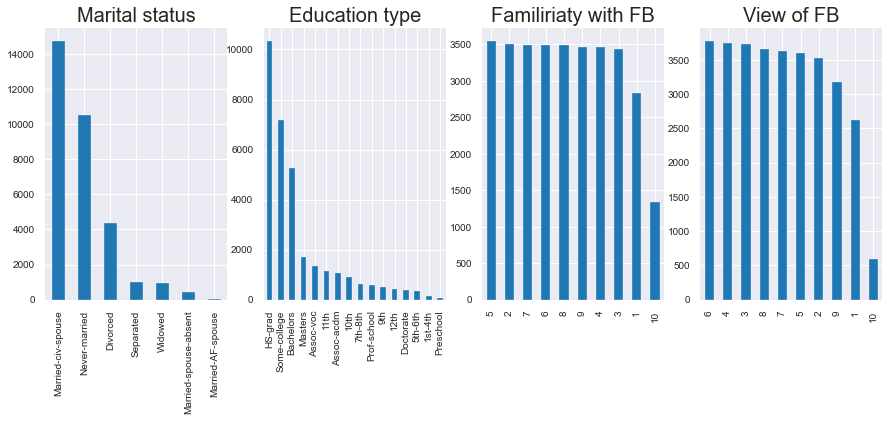

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
df_campaign['marital_status'].value_counts().plot.bar()
plt.title('Marital status', fontsize=20, ha='center')

plt.subplot(1,4,2)
df_campaign['education'].value_counts().plot.bar()
plt.title('Education type', fontsize=20, ha='center')

plt.subplot(1,4,3)
df_campaign['familiarity_FB'].value_counts().plot.bar()
plt.title('Familiriaty with FB', fontsize=20, ha='center')

plt.subplot(1,4,4)
df_campaign['view_FB'].value_counts().plot.bar()
plt.title('View of FB', fontsize=20, ha='center')

plt.show()

### The average individual in campaign
- #### Is Married
- #### High school grad or some college education
- #### In his 20s-30s
- #### With some knowledge about FB and neutral views about FB
- #### Also not very interested in insurance

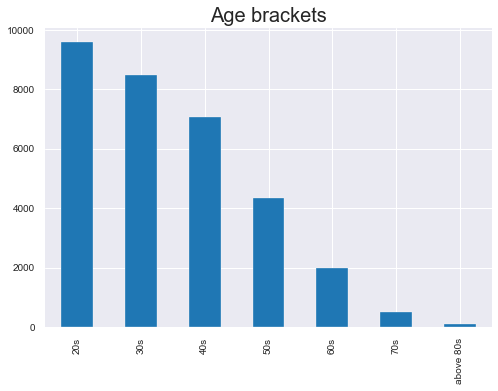

In [19]:
df_campaign['age_bracket'].value_counts().plot.bar()
plt.title('Age brackets', fontsize=20, ha='center')
plt.show()

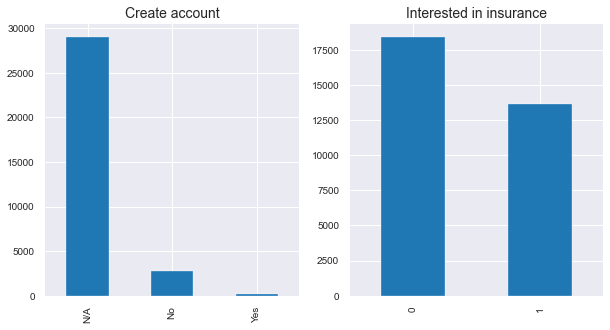

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Create account', fontsize=14)
df_campaign['created_account'].value_counts().plot.bar()

plt.subplot(1,2,2)
plt.title('Interested in insurance', fontsize=14)
df_campaign['interested_insurance'].value_counts().plot.bar()
plt.show()

### Removing columns

In [21]:
df_campaign.drop(['participant_id', 'postcode','company_email',
                  'name_title','first_name','last_name','age'],axis=1,inplace=True)

### Final campaign df

In [22]:
df_campaign.head(3)

,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account,full_name,age_bracket
0,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,No,Mr. Dale Coles,30s
1,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,No,Joel Allen,50s
2,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,No,Mr. Craig Davis,30s


## Mortgages data

In [23]:
df_mortgage = pd.read_csv('data/Mortgage.csv')

### General data profiling

In [24]:
profile = ProfileReport(df_mortgage, title="Mortgage Report")

In [25]:
profile.to_widgets()

In [26]:
print('Mortgage length: ', len(df_mortgage))
print('Mortgage columns: ',df_mortgage.shape[1])

Mortgage length:  32561
Mortgage columns:  18


### Checking NaN columns 

In [27]:
nan_cols = [i for i in df_mortgage.columns if df_mortgage[i].isnull().any()]
print('Columns containing NaN :', nan_cols)

Columns containing NaN : []


### Checking for duplicated columns 

In [28]:
print('Total number of duplicated columns :', df_mortgage.duplicated().sum())

Total number of duplicated columns : 0


### Checking mixed types columns

In [29]:
find_mix_types(df_mortgage)

'No mixed columns'

### Using the dob column to create new features
- #### First create birth_year 
- #### Then age 
- #### Finally age_bracket

In [30]:
df_mortgage['dob'] = pd.to_datetime(df_mortgage['dob'])
df_mortgage['birth_year'] = df_mortgage['dob'].dt.year
df_mortgage['age'] = 2022 - df_mortgage['birth_year']

In [31]:
make_bins(df_mortgage)

###  Drop columns

In [32]:
df_mortgage.drop(['paye','new_mortgage','dob','birth_year'],axis=1,inplace=True)

### Salary band normalization
- #### Many rows have salaries in foreign currencies as well as crypto abbreviations
- #### First extract the code from the salary_band e.g. SOS, then convert it to GBP using another function
- #### Also it is not known if the foreign amount is in pcw, pcm etc

In [33]:
## using this function to extract the country code from within the salary_band
def get_code(df):
    code = []
    for item in df['salary_band'].tolist():
        if type(item) ==str and item!='crypto':
            code.append(re.sub(r'[^a-zA-Z]', '', item))
        else:
            code.append('GBP')
    df['country_code'] = code

### Converting salary_band to yearly
- #### monthly amounts are x12
- #### weekly amounts are x52
- #### yearly amounts are left as is
- #### salaries in crypto names are marked as 'crypto'

In [34]:
df_mortgage['salary_band'] = df_mortgage['salary_band'].apply(lambda x: float(x.split()[0].replace('£','')) if 'yearly' in str(x) else x)
df_mortgage['salary_band'] = df_mortgage['salary_band'].apply(lambda x: float(x.split()[0].replace('£',''))*12 if 'month' in str(x) else x)
df_mortgage['salary_band'] = df_mortgage['salary_band'].apply(lambda x: float(x.split()[0].replace('£',''))*52 if 'pw' in str(x) else x)
df_mortgage['salary_band'] = df_mortgage['salary_band'].apply(lambda x: float(x.split()[0].replace('£',''))+float(x.split()[2])/2 if 'range' in str(x) else x)
df_mortgage['salary_band'] = df_mortgage['salary_band'].apply(lambda x: 'crypto' if len(str(x))<=5 else x)

#### 98 people are found to have a crypto name as their salary band 

In [35]:
print('Number of people with crypto in salary band :', len(df_mortgage.loc[df_mortgage['salary_band']=='crypto']))

Number of people with crypto in salary band : 98


In [36]:
get_code(df_mortgage) ### using the above function to get foreign codes

#### 3124 are paid in foreign currencies for which we dont know if its pcm, pw, py etc
- #### still a big chunk of the dataframe to simply drop (10%)

In [37]:
print('Number of people paid in foreighn currencies :', len(df_mortgage.loc[df_mortgage['country_code']!='GBP']))

Number of people paid in foreighn currencies : 3124


In [38]:
df_mortgage['salary_band'] = df_mortgage['salary_band'].apply(lambda x: '.'.join(re.findall("\d+", x)) if type(x)==str and len(str(x))>6 else x)

### Method using external libary trying to convert extracted foreign codes to GBP
- #### Failed as not many foreign codes are supported
- #### Another solution is being presented later for crypto/foreign salary_bands

In [39]:
def check_codes(lst):
    c = CurrencyConverter()
    not_supported = []
    for code in lst:
        if code!='GBP':
            try:
                conv.append(c.convert(10, code, 'GBP'))
            except:
                not_supported.append(code)
    return 'Total countries codes not supported:', len(set(not_supported))

In [40]:
check_codes(df_mortgage['country_code'].tolist())

('Total countries codes not supported:', 163)

### Final mortgage df 

In [41]:
df_mortgage.head(3)

,full_name,town,salary_band,years_with_employer,months_with_employer,hours_per_week,capital_gain,capital_loss,sex,religion,relationship,race,native_country,workclass,demographic_characteristic,age,age_bracket,country_code
0,Mr. Dale Coles,Edinburgh,18109.0,20,6,40,2174,0,Male,Christianity,Not-in-family,White,United Kingdom,State-gov,77516,43,40s,GBP
1,Joel Allen,Leeds,16945.0,28,1,13,0,0,Male,Christianity,Husband,White,United Kingdom,Self-emp-not-inc,83311,54,50s,GBP
2,Mr. Craig Marc Davis,Edinburgh,37953.24,14,5,40,0,0,Male,Christianity,Not-in-family,White,United Kingdom,Private,215646,43,40s,GBP


### Mortgage dataset visualisations
- #### Creating graphs to better understand the features 
- #### Interesting demographic features to look into 
- #### Get better knowledge and potentially discover patterns on the customerbase
- #### Help the business better identify trends and profiling on the mortgage dataset

### The average individual in mortgage
- #### Christian
- #### Male
- #### Married 
- #### Doesnt disclose race

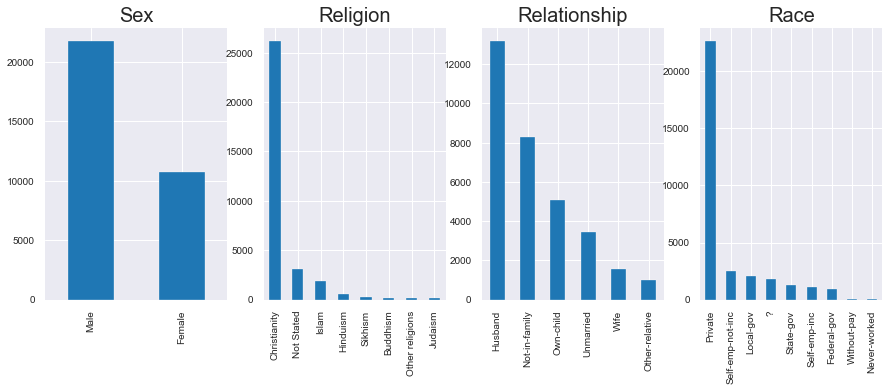

In [42]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
df_mortgage['sex'].value_counts().plot.bar()
plt.title('Sex', fontsize=20, ha='center')

plt.subplot(1,4,2)
df_mortgage['religion'].value_counts().plot.bar()
plt.title('Religion', fontsize=20, ha='center')

plt.subplot(1,4,3)
df_mortgage['relationship'].value_counts().plot.bar()
plt.title('Relationship', fontsize=20, ha='center')

plt.subplot(1,4,4)
df_mortgage['workclass'].value_counts().plot.bar()
plt.title('Race', fontsize=20, ha='center')

plt.show()

### Combining datasets
- #### Using full_name as unique Id to bring together the two sets
- #### This will produce a dataset of those who have taken part into the survey from the mortgage data
- #### The two datasets have really interested features when combined around demographics, employment and general views on  FB

In [43]:
df_mortgage['full_name'] =df_mortgage['full_name'].astype(str)
df_campaign['full_name'] = df_campaign['full_name'].astype(str)

In [44]:
df_total = pd.merge(df_mortgage, df_campaign,'inner','full_name')

In [45]:
print('Number of people in combined dataset :', len(df_total))

Number of people in combined dataset : 21350


In [46]:
df_total.rename({'age_bracket_y':'age_bracket'},axis=1,inplace=True)
df_total['age_bracket'] = df_total['age_bracket'].astype(str)
df_total.drop(['full_name'],axis=1,inplace=True)

### This is the most important step
- #### Out of the 21k data points of the combined dataset only 2k have intracted with the campaign
- #### Thus the data available to train the model is 2k points
- #### I decide to pick only those 2k points and drop those who are marked as N/A on created_account
- #### I have decided not to go forward with any sort of imputation on those N/A such as it would introduce great bias

In [47]:
df_adjusted = df_total.loc[df_total['created_account']!='N/A']

In [48]:
print('Total length of new df:',len(df_adjusted))
print('Campaign columns: ',df_adjusted.shape[1])

Total length of new df: 2033
Campaign columns:  27


### Imputing salary_band
- #### Foreign currencies and crypto make up 10% of the current data
- #### They are being marked as NaN and imputed using KNN
- #### KNN will allow to regain useuful information around those missing rows using the mean of their nearest neighbors as salary_band value
- #### There is also some tradeoff in introducing bias however, there is an adequate number of points and features to make assumptions

In [49]:
df_adjusted.loc[df_adjusted['country_code']!='GBP','salary_band']=np.nan
df_adjusted.loc[df_adjusted['salary_band']=='crypto','salary_band']=np.nan


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
print('Total number of NaNs in salary_band:', (df_adjusted.isna().sum().sum()))

Total number of NaNs in salary_band: 209


In [51]:
categoricals = [col for col in df_total.columns if df_adjusted[col].dtype=='O']

### Label encode the categorical features

In [52]:
label_encoder = preprocessing.LabelEncoder()
df_encoded = df_adjusted.apply(label_encoder.fit_transform)

In [53]:
df_encoded.shape

(2033, 27)

In [54]:
df_encoded.head(1)

,town,salary_band,years_with_employer,months_with_employer,hours_per_week,capital_gain,capital_loss,sex,religion,relationship,...,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account,age_bracket
0,37,305,20,6,34,8,0,1,1,1,...,4,9,143,0,12,6,8,0,0,1


### KNN is a distance based approach thus we want to scale our data
- #### Prevent bigger magnitude fetures to disort the distance metric using in the algorithms convergence

In [55]:
df_encoded.head(3)

,town,salary_band,years_with_employer,months_with_employer,hours_per_week,capital_gain,capital_loss,sex,religion,relationship,...,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,created_account,age_bracket
0,37,305,20,6,34,8,0,1,1,1,...,4,9,143,0,12,6,8,0,0,1
1,75,184,28,1,12,0,0,1,1,0,...,2,9,8,3,12,8,5,1,0,3
2,37,393,32,6,34,0,0,1,1,0,...,2,1,127,0,6,8,1,0,0,3


In [56]:
X = df_encoded.drop(['created_account'],axis=1)
y = df_encoded['created_account'].tolist()
scaler = StandardScaler()
model = scaler.fit(X)
scaled_data = model.transform(X)
scaled_data = pd.DataFrame(scaled_data)

In [57]:
scaled_data.shape

(2033, 26)

#### Using KNN to impute the NaNs in salary_band

In [58]:
imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(imputer.fit_transform(scaled_data),columns=X.columns.tolist())

In [59]:
print('Total number of NaNs in salary_band:', (df_imputed.isna().sum().sum()))

Total number of NaNs in salary_band: 0


In [60]:
df_imputed.drop(['age_bracket_x'],axis=1,inplace=True)
df_imputed['created_account'] = y

In [61]:
df_imputed.head(3)

,town,salary_band,years_with_employer,months_with_employer,hours_per_week,capital_gain,capital_loss,sex,religion,relationship,...,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,age_bracket,created_account
0,-0.628842,-1.180486,2.286323,0.136631,-0.078020,0.486289,-0.210625,0.649368,-0.45051,-0.227843,...,0.920583,-0.329860,0.168810,-1.734324,1.196285,0.617568,1.490468,-0.845938,-0.371277,0
1,0.031077,-1.408515,3.524247,-1.339306,-2.279617,-0.281054,-0.210625,0.649368,-0.45051,-0.866745,...,-0.396016,-0.329860,-1.395678,-0.948583,1.196285,1.359160,0.314483,1.182119,1.141361,0
2,-0.628842,-1.014647,4.143209,0.136631,-0.078020,-0.281054,-0.210625,0.649368,-0.45051,-0.866745,...,-0.396016,-2.372831,-0.016611,-1.734324,-1.206132,1.359160,-1.253497,-0.845938,1.141361,0


# Pattern exteaction
- #### Profiling customers and their interaction with the suggested product
- #### Identifying, compare and constrast the characteristics of those who bought the product vs those who didnt
- #### Useful in order to give suggestions to the marketing department or the business in general about the characteristics of those who interacted with the home insurance product

## Negative interaction
- #### Those who did not buy the product

In [62]:
df_no = df_total.loc[df_total['created_account']=='No']

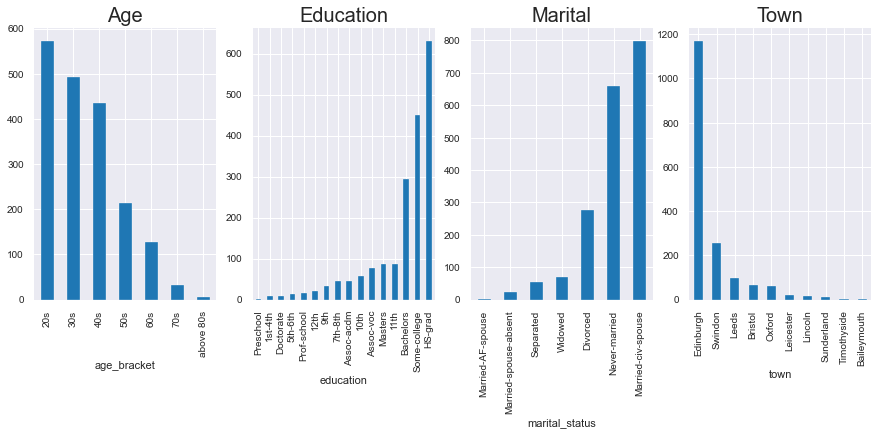

In [63]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
df_no.groupby(['age_bracket'])['created_account'].count().plot.bar()
plt.title('Age', fontsize=20, ha='center')

plt.subplot(1,4,2)
df_no.groupby(['education'])['created_account'].count().sort_values().plot.bar()
plt.title('Education', fontsize=20, ha='center')

plt.subplot(1,4,3)
df_no.groupby(['marital_status'])['created_account'].count().sort_values().plot.bar()
plt.title('Marital', fontsize=20, ha='center')

plt.subplot(1,4,4)
df_no.groupby(['town'])['created_account'].count().sort_values().nlargest(10).plot.bar()
plt.title('Town', fontsize=20, ha='center')

plt.show()

### The profile of the average individual who did not buy the product
- #### In his 20s-30s
- #### HS grad some college
- #### Married but also big portion of them isnt married yet
- #### Living in Edinburgh which is one of the biggest cities in the set
- #### Not intersted in insurance however, familiar with FB with a neutral view on them

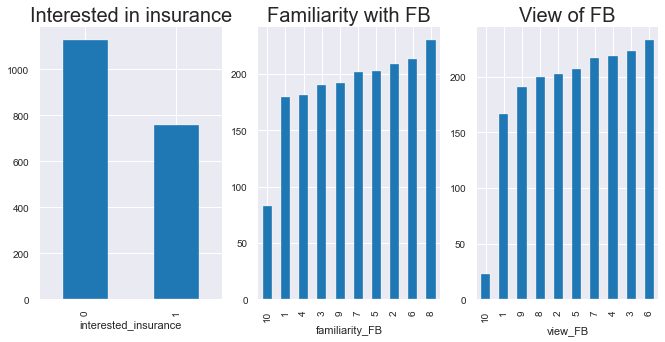

In [64]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
df_no.groupby(['interested_insurance'])['created_account'].count().plot.bar()
plt.title('Interested in insurance', fontsize=20, ha='center')

plt.subplot(1,4,2)
df_no.groupby(['familiarity_FB'])['created_account'].count().sort_values().plot.bar()
plt.title('Familiarity with FB', fontsize=20, ha='center')

plt.subplot(1,4,3)
df_no.groupby(['view_FB'])['created_account'].count().sort_values().plot.bar()
plt.title('View of FB', fontsize=20, ha='center')

plt.show()

## Positive interaction
- #### Those who did buy the product

In [65]:
df_yes = df_total.loc[df_total['created_account']=='Yes']

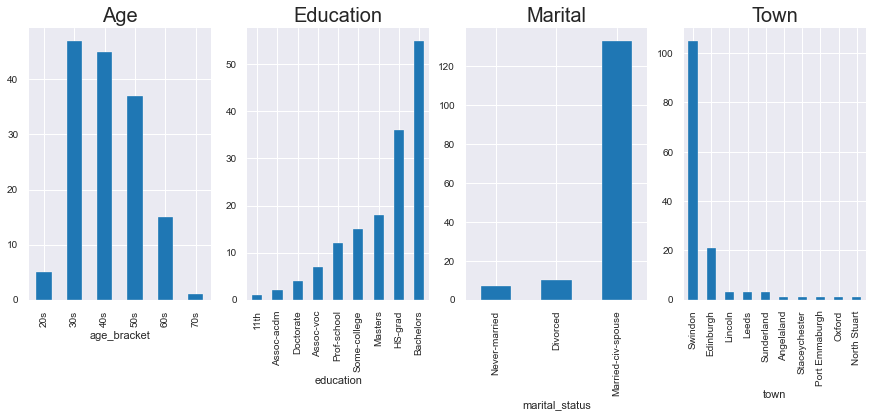

In [66]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
df_yes.groupby(['age_bracket'])['created_account'].count().plot.bar()
plt.title('Age', fontsize=20, ha='center')

plt.subplot(1,4,2)
df_yes.groupby(['education'])['created_account'].count().sort_values().plot.bar()
plt.title('Education', fontsize=20, ha='center')

plt.subplot(1,4,3)
df_yes.groupby(['marital_status'])['created_account'].count().sort_values().plot.bar()
plt.title('Marital', fontsize=20, ha='center')

plt.subplot(1,4,4)
df_yes.groupby(['town'])['created_account'].count().sort_values().nlargest(10).plot.bar()
plt.title('Town', fontsize=20, ha='center')

plt.show()

### The profile of those who bought the product
- #### 30s- 40s
- #### Educated to Bachelor degree
- #### Married
- #### Living in a smaller city
- #### Interested in insurance, somewhat familiar with FB with a strong positive view towarrds FB

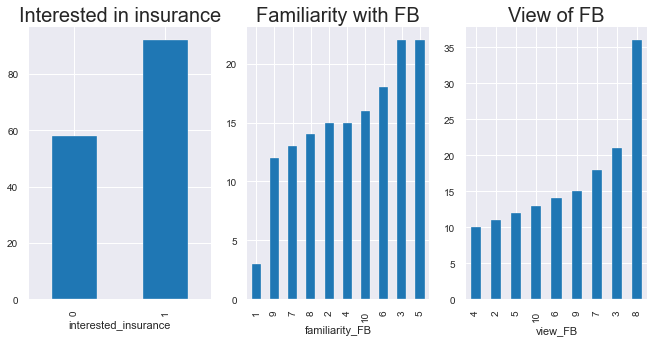

In [67]:
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
df_yes.groupby(['interested_insurance'])['created_account'].count().plot.bar()
plt.title('Interested in insurance', fontsize=20, ha='center')

plt.subplot(1,4,2)
df_yes.groupby(['familiarity_FB'])['created_account'].count().sort_values().plot.bar()
plt.title('Familiarity with FB', fontsize=20, ha='center')

plt.subplot(1,4,3)
df_yes.groupby(['view_FB'])['created_account'].count().sort_values().plot.bar()
plt.title('View of FB', fontsize=20, ha='center')

plt.show()

### Comparing the two profiles
- #### It seems that younger people, maybe they are not married yet or maybe they havent finished their studies, are not as interested in home insurance products
- #### On the other hand older people that are settled down, they had their education degrees and are keen on insurance all togehter, are more interested in a home insurance product
- #### As far as the town is concerned, it seems that people who live in a relatively bigger city are not interested in home insurance as much as those living in a smaller city. This might be due to the fact that people in big cities tend to rent flats against those who might be settled in a smaller city. Thus they dont opt for home security in rented flats
- #### Business-wise it does make sense for older people to tend to be more keen on a home insurance product against younger ones

# Data preprocessing prior to modeling 
- #### Feature correlation to detect multicolinearity
- #### Feature selection
- #### Split data to train, test, val
- #### Resampling the target values
- #### Outlier detection

### Feature correlation
- #### Using Pearsons linear correlation to determine multicolinearity in the dataset
- #### This will help with model decision
- #### Also better understand the domain knowledge by observing how features engage with each other and offer more explainability to the business around the features interactions
    - #### Age bracket and years with employer have high corelation which does make sense as a more senior person could stick to a company longer
    - #### Salary band is highly correlated with occupational level which is also right as better job means better many and vice versa
    - #### Capital gain and capital loss seem to be both higly correlated with create account thus leading to believe that people who invest overall tend to take into consideration the product
    - #### Contrar sex and age tend to be negatevily correlated with relationship which by nature is true as reationships are not restricted to a specific age or sex

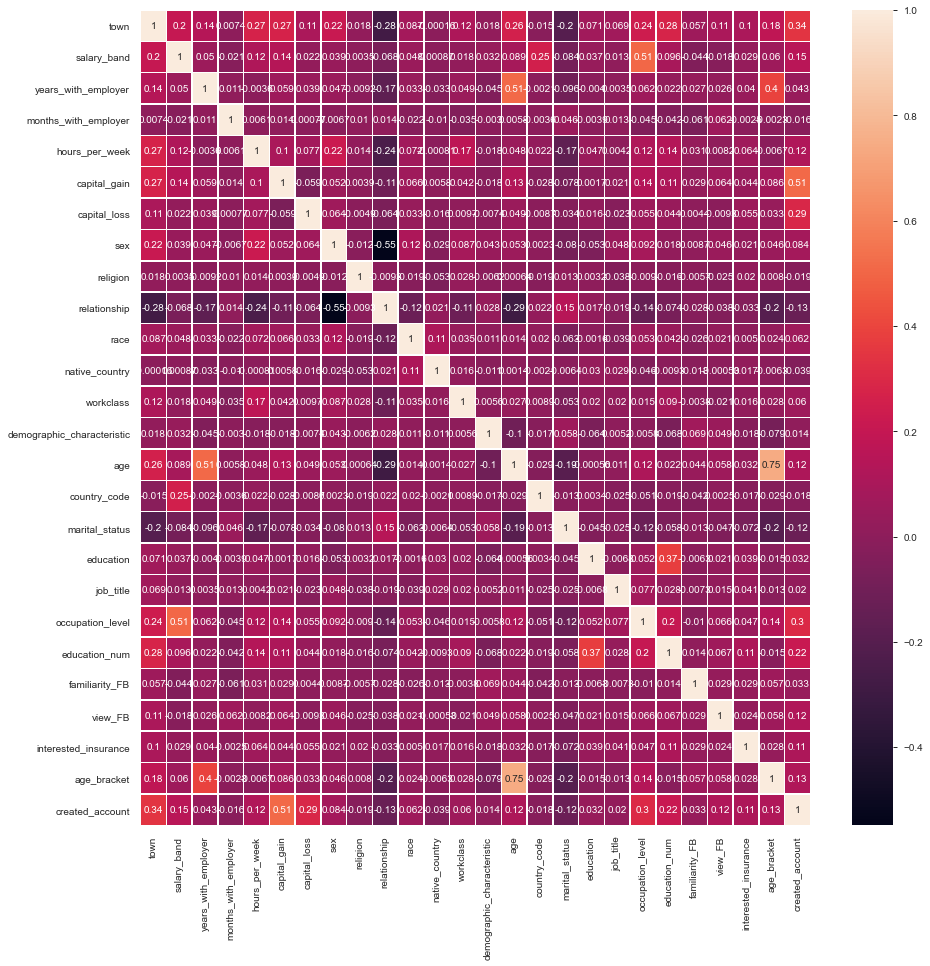

In [68]:
fig, ax = plt.subplots(figsize=(15,15))   
sns.heatmap(df_imputed.corr(), annot=True, linewidths=.5)
plt.show()

## Feature selection

### Using ExtraTree classifier to calculate the best features
- #### Selectoon based on Gini index 
- #### Those will be used for the model training

In [73]:
X = df_imputed.drop(['created_account'],axis=1)
y = df_imputed['created_account']

In [74]:
def feature_importance(X,y,n_larg):
    model = ExtraTreesClassifier(n_estimators = 100, random_state = 42)
    model.fit(X, y)
    feat_importances = pd.Series(model.feature_importances_, index = X.columns)
    feat_importances.nlargest(n_larg).plot(figsize=(8,6), kind='barh')
    plt.title('Top n important features')
    plt.show()
    return feat_importances.nlargest(n_larg).index.tolist()

### Visualising the top 10 features
- #### Business-wisethe the top features below make sense as to how they influnce an individiaul towards a home insurance product
- #### capital_gain/capital_loss play an important role for people to buy the product
- #### Town also seems an important factor for someone to buy a home product or not (small town/bigger town effect above)
- #### Occupation, salary, age and education are also important as mentioned previously in the profilling

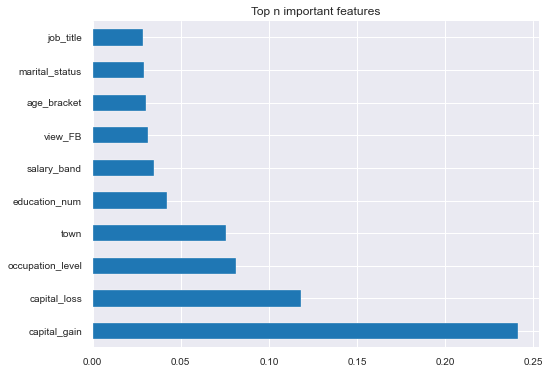

In [75]:
top_features = feature_importance(X,y,10)
top_features.append('created_account')

In [76]:
df_new_features = df_imputed[top_features]

## Outlier detection
- #### Important to identify outliers as they might skew the predictive power of the model
- #### Intersted in finding outliers in the whole feature space rather than per feature
- #### Thus using a multivariate approach, Mahalanobis distance
- #### Using p value to determine them

In [77]:
def mahalanobis(X=None,data=None,cov=None):
    x_mu = X-np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left,x_mu.T)
    return mahal.diagonal()

In [78]:
df_mahal = df_new_features.copy()
df_mahal['Mahalanobis_Dis']=mahalanobis(df_mahal.select_dtypes(['float']),df_mahal.select_dtypes(['float']))
df_mahal['p_value'] = 1-chi2.cdf(df_mahal['Mahalanobis_Dis'], df_mahal.shape[1]-3)

In [79]:
print('Number of outliers found:',len(df_mahal.loc[df_mahal['p_value']<0.001]))

Number of outliers found: 55


## 55 outliers found with the above method
- #### Checking the distribution of target within the outliers
- #### Most of the outliers can be found in the majority class
- #### Mos of the times multivariate outliers need to be removed

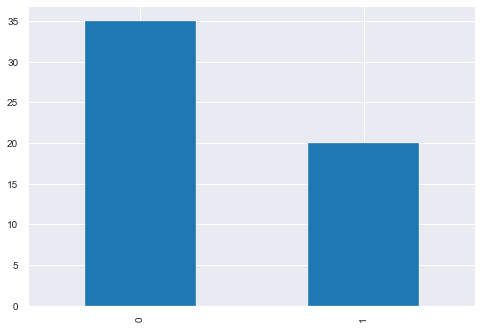

In [80]:
df_mahal.loc[df_mahal['p_value']<0.001]['created_account'].value_counts().plot.bar()
plt.show()

In [81]:
out_idx = df_mahal.loc[df_mahal['p_value']<0.001]['created_account'].index

In [82]:
df_new_features = df_new_features.drop(index=out_idx)

## Data splits
- #### Creating train, test and validation splits
- #### Validation will be used on Grid Search to estimate the better parameters

In [83]:
X = df_new_features.drop(['created_account'],axis=1)
y = df_new_features['created_account']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=43)

print('Train length : ',len(X_train), len(y_train))
print('Test length : ',len(X_test), len(y_test))
print('Validation length : ',len(X_val), len(y_val))

Train length :  1107 1107
Test length :  594 594
Validation length :  277 277


## Resampling
- #### The dataset is highly imbalanced
- #### Multiple approaches such as downsampling the majority class, oversampling the minority 
- #### Undersampling is not selected because it will reduce the dataset which is already limited
- #### SMOTE will create artificial points of the minority class and rebalance the target

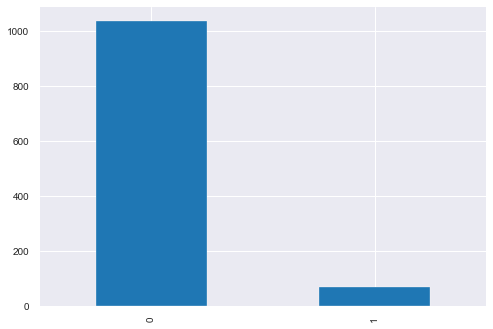

In [85]:
y_train.value_counts().plot.bar()
plt.show()

#### Resampling 

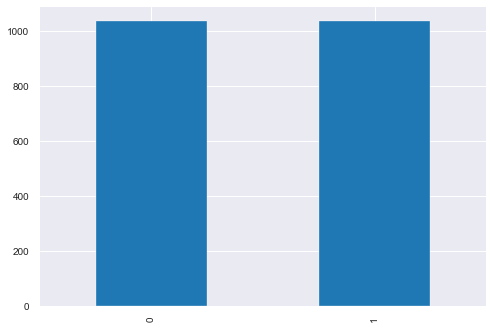

In [86]:
sm = SMOTE(random_state=43)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
y_train_sm.value_counts().plot.bar()
plt.show()

# Modeling
- #### Model selection
- #### Grid search
- #### Baseline model vs GS model
- #### Model Perfomance
- #### Model Feature importance
- #### SHAP explainability

## Model selection
- #### Model of choice is XGBoost
- #### There is multicolinearity on the data thus a linear model would suffer more. XGB is more robust due to the way features are split
- #### Since its an imbalanced dataset XGB has internal parameters to control overfitting subsample, max_depth, min_child_weight
- #### Fast in terms of performance

## Grid Search

In [87]:
xgb_fi = XGBClassifier(random_state=43)

In [88]:
def grid_search(model,X,y,params,eval_metric,folds):
    grid = GridSearchCV(estimator=model,
                     param_grid=params,
                     scoring=eval_metric,
                     cv=folds,
                     verbose=1)
    grid.fit(X,y)
    print('Best params are: ', grid.best_params_)
    return grid.best_params_

### Parameter selection
- #### max_depth - allows to control the complexity of the model
- #### learning_rate - how fast the model changes in response to the error per iteration
- #### min_child_weight - also controls overfitting by splitting the nodes thus avoid highly specific relations to form
- #### subsample - controls overfitting by selecting random observations per tree

In [89]:
parameters = {'max_depth': range(2,5),
             'learning_rate':[0.1,0.01],
             'min_child_weight':[0.5,1.5],
             'subsample':[0.5,0.6,1]}

###  The evaluation metric for the Grid Search is F1
- #### The business problem calls for a model to identify more people willing to buy the new product
- #### Thus the model shouldnt miss those people who want the product and mark as the opposite
- #### Therefore we need the model to minimise the False Negatives
- #### Minimising FN leads to increased Recall 
- #### Greater numbers of Recall will boost the F1 as it is greatly dependand on Recall

In [ ]:
best_params = grid_search(xgb_fi,X_val,y_val,parameters,'f1',5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [112]:
best_params ={'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 0.5, 'subsample': 1}

#### Function to plot various loss functions

In [113]:
def binary_classification_performance(y_test, y_pred, model):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall) 
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)
    model_name = model
    result = pd.DataFrame({
                         'Model' : [model_name],
                         'Precision' : [precision],
                         'Recall': [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]
                        })
    return result

#### Function to plot loss curves

In [114]:
def plot_loss(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0,epochs)
    fig,ax = plt.subplots(figsize=(6,6))
    ax.plot(x_axis,results['validation_0']['error'],label='train')
    ax.plot(x_axis,results['validation_1']['error'],label='test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('Model error')
    plt.show()

#### Return model prediction 

In [115]:
def return_preds(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train, eval_metric=['error'],eval_set=[(X_train,y_train),(X_test,y_test)])
    pred = model.predict(X_test)
    return pred

### Train GS and baseline model 

In [119]:
xgb_base = XGBClassifier(random_state=42)
base_pred = return_preds(xgb_base,X_train_sm,X_test,y_train_sm,y_test)
based_df = binary_classification_performance(y_test,base_pred,'base_model')

[0]	validation_0-error:0.05877	validation_1-error:0.11280
[1]	validation_0-error:0.03372	validation_1-error:0.07576
[2]	validation_0-error:0.03372	validation_1-error:0.07913
[3]	validation_0-error:0.02649	validation_1-error:0.07576
[4]	validation_0-error:0.02697	validation_1-error:0.07239
[5]	validation_0-error:0.02601	validation_1-error:0.07071
[6]	validation_0-error:0.02360	validation_1-error:0.07239
[7]	validation_0-error:0.02119	validation_1-error:0.06902
[8]	validation_0-error:0.01927	validation_1-error:0.05892
[9]	validation_0-error:0.01927	validation_1-error:0.06229
[10]	validation_0-error:0.01734	validation_1-error:0.06061
[11]	validation_0-error:0.01734	validation_1-error:0.06061
[12]	validation_0-error:0.01590	validation_1-error:0.05892
[13]	validation_0-error:0.01349	validation_1-error:0.05724
[14]	validation_0-error:0.01012	validation_1-error:0.05892
[15]	validation_0-error:0.01108	validation_1-error:0.05892
[16]	validation_0-error:0.01060	validation_1-error:0.06061
[17]	va

In [120]:
xgb_GS = XGBClassifier(random_state=42,params=best_params)
GS_pred = return_preds(xgb_GS,X_train_sm,X_test,y_train_sm,y_test)
Gs_df = binary_classification_performance(y_test,GS_pred,'GS_model')

[0]	validation_0-error:0.05877	validation_1-error:0.11280
[1]	validation_0-error:0.03372	validation_1-error:0.07576
[2]	validation_0-error:0.03372	validation_1-error:0.07913
[3]	validation_0-error:0.02649	validation_1-error:0.07576
[4]	validation_0-error:0.02697	validation_1-error:0.07239
[5]	validation_0-error:0.02601	validation_1-error:0.07071
[6]	validation_0-error:0.02360	validation_1-error:0.07239
[7]	validation_0-error:0.02119	validation_1-error:0.06902
[8]	validation_0-error:0.01927	validation_1-error:0.05892
[9]	validation_0-error:0.01927	validation_1-error:0.06229
[10]	validation_0-error:0.01734	validation_1-error:0.06061
[11]	validation_0-error:0.01734	validation_1-error:0.06061
[12]	validation_0-error:0.01590	validation_1-error:0.05892
[13]	validation_0-error:0.01349	validation_1-error:0.05724
[14]	validation_0-error:0.01012	validation_1-error:0.05892
[15]	validation_0-error:0.01108	validation_1-error:0.05892
[16]	validation_0-error:0.01060	validation_1-error:0.06061
[17]	va

## Model performance
- #### For some reason both models have identical performance I must have messed up somewhere in the trainin above!
- #### The models seem to have a poor F1 score that derives from low Reall and Precision
- #### A high number of TN is worrying as the dataset is imbalanced thus everything could be marked as 0 meaning the model could have no predictive power
- #### The metric to chose from if the models were different would be first F1 then Recall

In [121]:
df_models = pd.concat([based_df,Gs_df])

In [122]:
df_models

,Model,Precision,Recall,f1 score,AUC_ROC,True Positive,True Negative,False Positive,False Negative
0,base_model,0.659091,0.674419,0.666667,0.82,29,536,15,14
0,GS_model,0.659091,0.674419,0.666667,0.82,29,536,15,14


### Plotting the loss curves during training and testing 
- #### High testing error combined with low training error indicates the model is overfitting
- #### The model is not able to generalise welll on unseen data

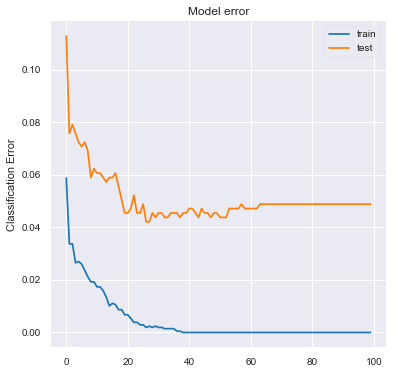

In [123]:
plot_loss(xgb_base)

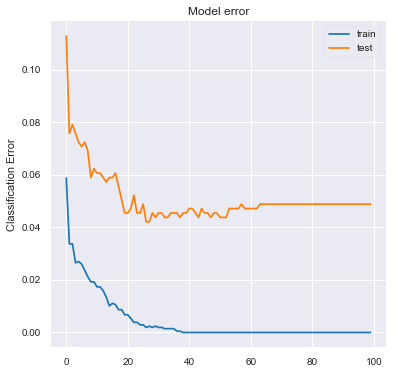

In [124]:
plot_loss(xgb_GS)

## Model feature importance
- #### Feature importance for the above model
- #### Interesting to compare and contrast with previous feature importance
- #### capital gain and loss seem to hold less weight for this model
- #### Occupation_level, salary_band, view_FB and eduation_num seem to be more dominant

In [127]:
def plot_importances(model,n_largest):
    feature_important = model.get_booster().get_score(importance_type='weight')
    keys = feature_important
    values = list(feature_important.values())
    data = pd.DataFrame(data=values,index=keys,columns=['score']).sort_values(by='score',ascending=False)
    data.head(n_largest).plot.barh()
    plt.show()

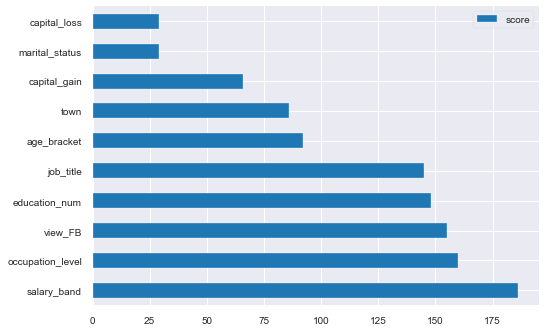

In [128]:
plot_importances(xgb_GS,10)

## SHAP explainability
- #### Using SHAP values to explain the model decision in three different scenarios. Provide model explainability to help better understand model predictions as well as the domain.
 #### 1. For the whole dataset of predictions
 #### 2. Per prediction
 #### 3. Per missclassified prediction. Essentially anything below the 0.7 classification threshold

In [129]:
explainer = shap.Explainer(xgb_GS,X_train_sm)
shap_values = explainer(X_train_sm)

# Model explainability
- ### It is observed that certain feature values drive the classification towards a specific point. The features with the most influence on the classification seem to be similar with those in feature selection.
    - #### Low level of capital_gal tends to people not buying the product. This implies that if someone doesnt invest might not be interested in the product.
    - #### On the contrary people with high values of capital_gain tend to buy the product more. Thus leading to believe that influx/loss of capital is associated with insurance.
    - #### Town is also a decisive factor for home insurance, which seems very reasonable. People how own their house in smaller cities might be interested in insurance. People who rent flats in bigger cities are not.
    - #### Occupation and education also play a role towards buying the product. Better job and higher education levels might indicate an older person who wants home insurance and vice versa.
    - #### Marital status is also a decisive factor about the home insurance product. People who are settled down maybe tend to be more interested in such a product.

### Total

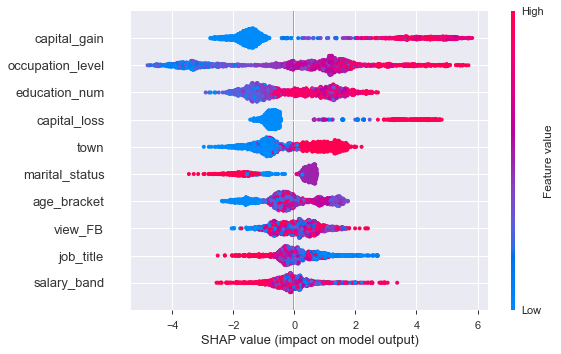

In [130]:
shap.plots.beeswarm(shap_values)

### Per prediction 

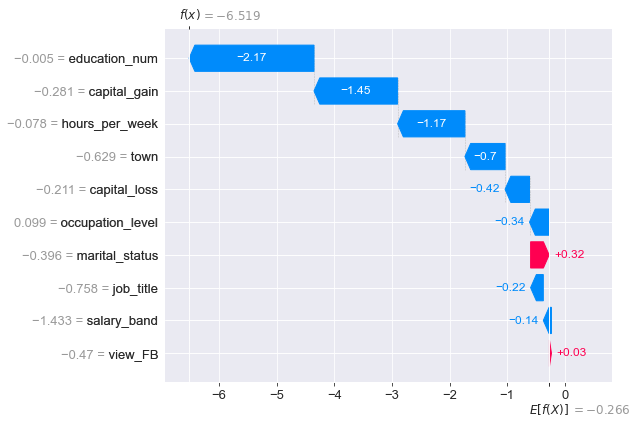

In [107]:
shap.plots.waterfall(shap_values[0])

### Missclassified

In [108]:
missclassified = (GS_pred!=0.7) & (y_test==1)
explainer = shap.TreeExplainer(xgb_GS)
shap_values = explainer.shap_values(X_test)

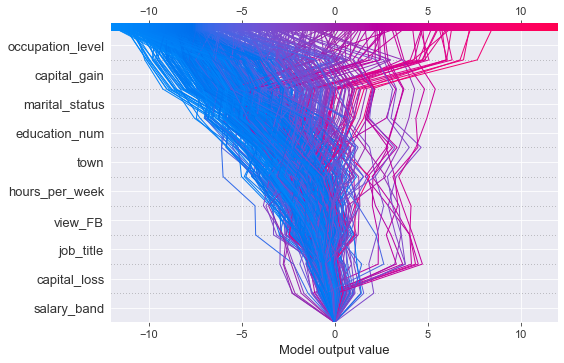

In [109]:
shap.decision_plot(explainer.expected_value, shap_values, X_test[missclassified],ignore_warnings=True)

# Suggestions for further improvement

### Data related suggestions
- #### Add more data to help the model better seperate the two classes (0,1)
- #### Follow a different resampling strategy e.g. undersample or Adasyn
- #### Select a different subset of features for training and evaluation

### Model related suggestions
- #### Make the model less complex by adjusting max_depth
- #### Enable earlystopping to prevent overfitting
- #### Adjust scale_pos_weight to cater for the data imbalances
- #### Add alpha and lambda regularization to help with overfitting
- #### Adjust the classification threshold to minimise the desired loss function while keeping in mind the overal business cost